Splice Junction Classification from Sequences
Instructions:

You will work on classifying DNA sequences (it is a 3-class classification problem).

The following code will import the Splice-junction Gene Sequences Data Set from the UCI repository as a Pandas DataFrame.

First, you need to preprocess the data. It contains string values, but you need to convert each sample to numerical values to be able to feed it into ML algorithms.

Although normal sequence characters are A T G or C, there are some values as D N S and R which were described in dataset source. Yoou need to handle them with care.

Finally, you will apply machine learning models to make predictions and compare them with proper metrics.
Double-click (or enter) to edit

You are supposed to try different classification methods and apply best practices we have seen in the lectures such as grid search, cross validation, regularization etc.

The dataset is related to molecular biology, specifically addressing the problem of recognizing splice junctions in DNA sequences. Splice junctions are points in a DNA sequence where unnecessary portions (introns) are removed during the process of protein creation in higher organisms. The goal of this dataset is to identify the boundaries between exons (retained parts) and introns (spliced-out parts).

Problem Description:

Task: Recognizing boundaries between exons and introns (EI sites) and introns and exons (IE sites) in DNA sequences. Terminology: IE borders are referred to as "acceptors," and EI borders are referred to as "donors." Dataset Size:

The dataset contains a total of 3,190 examples.


In [201]:
import itertools
import numpy as np
import pandas as pd
from sklearn import datasets
from matplotlib import pyplot

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import polynomial_kernel

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import polynomial_kernel
import pandas as pd

In [202]:
#loading data into pandas dataframe
import pandas as pd

# Load the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data'
names = ['Class', 'id', 'Sequence']
data = pd.read_csv(url, names=names)



The number of rows and column

In [203]:
# code in this cell
# Fetching the number of rows and columns
rows_count = data.shape[0]
columns_count = data.shape[1]

# Print the results
print(f"Number of rows is: {rows_count}")
print(f"Number of columns is: {columns_count}")

Number of rows is: 3190
Number of columns is: 3


The datatypes of each column

In [204]:
# Fetching  data types of each column
column_data_types = data.dtypes

# Printing the datatypes
print("Data Types of Each Column:")
print(column_data_types)

Data Types of Each Column:
Class       object
id          object
Sequence    object
dtype: object


In [205]:
#printing the dataframe before preprocessing
data.head()

,Class,id,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


In [206]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3190 entries, 0 to 3189
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     3190 non-null   object
 1   id        3190 non-null   object
 2   Sequence  3190 non-null   object
dtypes: object(3)
memory usage: 74.9+ KB


In [207]:
data.describe()

,Class,id,Sequence
count,3190,3190,3190
unique,3,3178,3092
top,N,HUMALBGC-ACCEPTOR-18496,CTCCCCACCCACCTGTCCACCCGCCCGCAGATCGCTTC...
freq,1655,2,3


<Axes: >

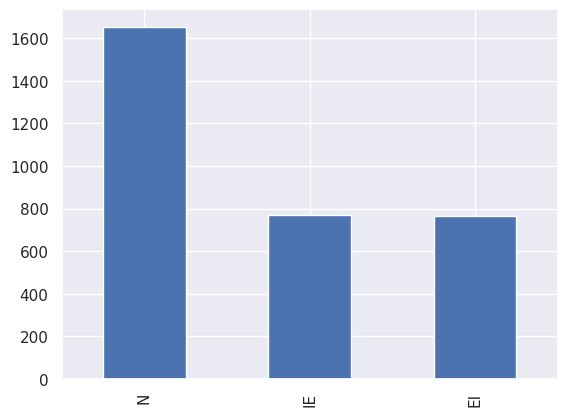

In [208]:
# visualization
data.Class.value_counts().plot(kind = 'bar')

Missing Data Analysis

In [209]:
# Checking for missing values
missing_values = data.isnull().any()

# Printing the missing values.
if missing_values.any():
    print("There are missing values in the DataFrame.")
    print("Columns with missing values:")
    print(missing_values[missing_values])
else:
    print("No missing values found in the DataFrame.")

No missing values found in the DataFrame.


Handling duplicate values

In [210]:
data.duplicated().sum()


12

In [211]:
# Keeping the first occurrence and remove subsequent duplicates
data = data.drop_duplicates(keep='first')


In [212]:
data.duplicated().sum()

0

Converting 'D' with 'A'; 'N'with 'A';'S' with 'C' ; 'R' with 'A'

In [213]:
data['Sequence'] = data['Sequence'].apply(lambda seq: seq.replace('D', 'A').replace('N', 'A').replace('S', 'C').replace('R', 'A'))

In [214]:

# Droping the 'id' column since it is not meaningful for features
data.drop('id', axis=1, inplace=True)



In [215]:
data

,Class,Sequence
0,EI,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...
...,...,...
3185,N,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTT...
3186,N,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAA...
3187,N,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCG...
3188,N,ATTCTACTTAGTAAACATAATTTCTTGTG...


 The code belowtakes a DataFrame (data) with a 'Sequence' column containing DNA sequences. It then converts each sequence into a set of dummy variables where each character in the sequence gets its own column with binary values (0 or 1). The resulting DataFrame (data) is an extended version that includes these new dummy variables, making it suitable for machine learning models that require numerical input.

In [216]:
# Assuming 'Sequence' is a string column with sequences, we can split it into individual characters
# and create new columns for each character
sequence_split = data['Sequence'].apply(lambda x: pd.Series(list(x.strip())))

# Create dummies for each character
sequence_dummies = pd.get_dummies(sequence_split, prefix='Sequence')

# Concatenate the dummies with the original data
data = pd.concat([data, sequence_dummies], axis=1)

# Drop the original 'Sequence' column
data.drop('Sequence', axis=1, inplace=True)

# Map integer class labels to string representation
class_mapping = {'N': 0, 'EI': 1, 'IE': 2}
data['Class'] = data['Class'].map(class_mapping)

# Display the first few rows of the DataFrame
data.head()

,Class,Sequence_A,Sequence_C,Sequence_G,Sequence_T,Sequence_A,Sequence_C,Sequence_G,Sequence_T,Sequence_A,...,Sequence_G,Sequence_T,Sequence_A,Sequence_C,Sequence_G,Sequence_T,Sequence_A,Sequence_C,Sequence_G,Sequence_T
0,1,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,1,1,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [217]:
# code in this cell

#The following code will load the  dataset :
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Class', axis=1),
    data['Class'],
    test_size=0.4,
    random_state=42
)
#train_test_split(X, y, test_size=.4, random_state=42)

In [218]:
# code in this cell

from sklearn.preprocessing import MinMaxScaler

# Initializing MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the scaler on the training data
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Logistic Regression

In [219]:
import numpy as np
import pandas as pd
from sklearn import datasets
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

# Get feature names
feature_names = X_train.columns
#lr_orig = LogisticRegression(penalty='l2', C=1.0, fit_intercept=True, solver='lbfgs', max_iter=100, multi_class='auto')
# l2 is the choice of regularization term, C is the inverse of regularization strength (lambda)
lr_orig = LogisticRegression()
lr_orig.fit(X_train_s,y_train)   #(X,y)
#help(train_df.drop)

#print(lr_orig.coef_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [220]:
y_pred_lr = lr_orig.predict(X_test_s)

In [221]:
# code in this cell
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Calculating the accuracy

acc_lr=accuracy_score(y_test, y_pred_lr)
print("Accuracy for LR:",acc_lr)

Accuracy for LR: 0.9457547169811321


The default value for C in scikit-learn's LogisticRegression is 1.0. This default setting means moderate regularization. If we increase the value of C, we decrease the strength of regularization, and the model may fit the training data more closely, potentially capturing noise and leading to overfitting. Conversely, if we decrease the value of C, you increase the strength of regularization, and the model tends to generalize better but might underfit the training data.

Finding Hyperparameter

In [222]:
# for  C = 10^-4 to 10^2 soothing parameter
Cs = np.logspace(-4, 2,40)
print(Cs.shape)
print(Cs)

grid_params = [
    {'C': Cs}
]
n_folds = 10

clf = GridSearchCV(LogisticRegression(solver='liblinear'), grid_params, cv=n_folds, refit=True)
clf.fit(X_train_s, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
print(scores, scores_std)

(40,)
[1.00000000e-04 1.42510267e-04 2.03091762e-04 2.89426612e-04
 4.12462638e-04 5.87801607e-04 8.37677640e-04 1.19377664e-03
 1.70125428e-03 2.42446202e-03 3.45510729e-03 4.92388263e-03
 7.01703829e-03 1.00000000e-02 1.42510267e-02 2.03091762e-02
 2.89426612e-02 4.12462638e-02 5.87801607e-02 8.37677640e-02
 1.19377664e-01 1.70125428e-01 2.42446202e-01 3.45510729e-01
 4.92388263e-01 7.01703829e-01 1.00000000e+00 1.42510267e+00
 2.03091762e+00 2.89426612e+00 4.12462638e+00 5.87801607e+00
 8.37677640e+00 1.19377664e+01 1.70125428e+01 2.42446202e+01
 3.45510729e+01 4.92388263e+01 7.01703829e+01 1.00000000e+02]
[0.52885643 0.52885643 0.52885643 0.52885643 0.52885643 0.54512538
 0.63589143 0.7586663  0.85572885 0.91082116 0.932345   0.94440617
 0.95016533 0.95173602 0.95330118 0.9538275  0.95540645 0.9554092
 0.95226509 0.95226233 0.95174153 0.95069165 0.94964453 0.95017085
 0.94808212 0.94598512 0.94336732 0.94231469 0.94021218 0.93705704
 0.93389915 0.93232295 0.93022045 0.92917333 0.92

In [223]:
clf.best_score_

0.9554092036373655

In [224]:
print('Test set score after CV: ', accuracy_score(y_test, clf.predict(X_test_s)))

Test set score after CV:  0.9575471698113207



##Random Forests
Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputs the class that is the mode of the classes (classification)

Advantages of Random Forest:

Reduced Overfitting: The randomness introduced during training helps prevent overfitting by creating diverse trees that collectively generalize well to new data.


High Accuracy: Random Forests often achieve high accuracy and are robust to noise and outliers.


Feature Importance: Random Forests can provide a measure of feature importance, helping identify which features contribute the most to the predictions.


Handling Missing Values: Random Forests can handle missing values without the need for imputation.

Versatility: Suitable for both classification and regression tasks.



In [225]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, precision_recall_curve, confusion_matrix

In [226]:
# Fitting the classifiers into the Training set
# RFC - fast
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_s,y_train)
y_pred = classifier.predict(X_test_s)
# print(y_Pred)
acc_rfc=accuracy_score(y_test,y_pred)
print('Accuracy score for RFC:',acc_rfc)

Accuracy score for RFC: 0.9685534591194969


The RandomizedSearchCV will then perform a randomized search over the specified parameter grid, evaluating the model performance using cross-validation with the chosen metric (F1 score in this case). The goal is to find the combination of hyperparameters that maximizes the F1 score.

In [227]:
# Fitting the classifiers into the Training set
# RFC - fast
print('Training RandomForest Classification Model:')
# Define a parameter grid to search over
params = {
    "class_weight": ['balanced', 'balanced_subsample'],
    "criterion": ['gini', 'entropy']
}
classifier_RFC = RandomForestClassifier()
cv_RFC = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Creating a RandomizedSearchCV object to search over the parameter grid
classifier_RFC = RandomizedSearchCV(classifier_RFC, param_distributions=params, scoring='f1', cv=cv_RFC, n_jobs=-1, verbose=3)
#train te model
classifier_RFC.fit(X_train_s,y_train)
y_pred = classifier_RFC.predict(X_test_s)
# print(y_Pred)
acc_rfc1=accuracy_score(y_test,y_pred)

Training RandomForest Classification Model:
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


In [228]:
# Print the best parameters found by RandomizedSearchCV
print("Best parameters found by RandomizedSearchCV for Random Forest Classifier:", classifier_RFC.best_params_)
# Print the accuracy score found by RandomizedSearchCV
print("Accuracy score for Random Forest Classifier:", acc_rfc1)

Best parameters found by RandomizedSearchCV for Random Forest Classifier: {'criterion': 'gini', 'class_weight': 'balanced'}
Accuracy score for Random Forest Classifier: 0.9614779874213837


In [229]:
#Generating classification report
# Use cross_validate to generate predictions on the training set
cv_results_RFC = cross_validate(classifier_RFC.best_estimator_, X_train_s, y_train, cv=5, scoring='f1', return_estimator=True, n_jobs=-1)

# Generate the classification report from the cross-validated results
y_train_pred = cv_results_RFC['estimator'][cv_results_RFC['test_score'].argmax()].predict(X_train_s)
print("Classification report generated from the results of RandomForestClassifier:")
print(classification_report(y_train, y_train_pred))

# Set the font scale of the seaborn plots
sns.set(font_scale=1)

Classification report generated from the results of RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1008
           1       0.99      0.99      0.99       446
           2       0.99      0.98      0.98       452

    accuracy                           0.99      1906
   macro avg       0.99      0.99      0.99      1906
weighted avg       0.99      0.99      0.99      1906



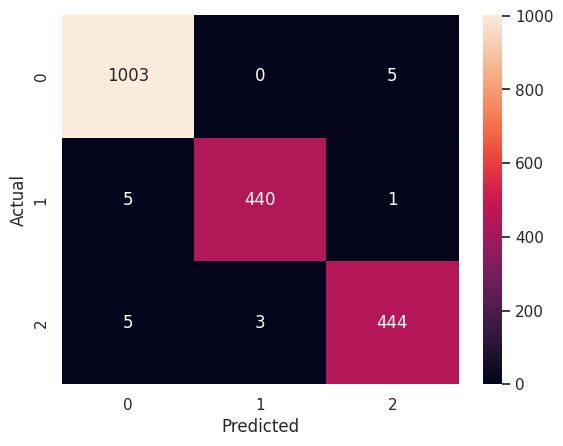

In [230]:
def show_classification_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt="0")
  ax = plt.gca()
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Actual")

show_classification_matrix(y_train, y_train_pred)

Decision Tree

In [231]:

import pandas as pd
import numpy as np
from sklearn import datasets
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
#new tricks
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree as tr

In [232]:
# Training data set into Decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=5)
#DecisionTreeClassifier(criterion='entropy')   #default criterion is 'gini'
#help(DecisionTreeClassifier)
tree.fit(X_train_s,y_train)   #equivalent to tree.fit(X,y)

DecisionTreeClassifier(max_depth=5)

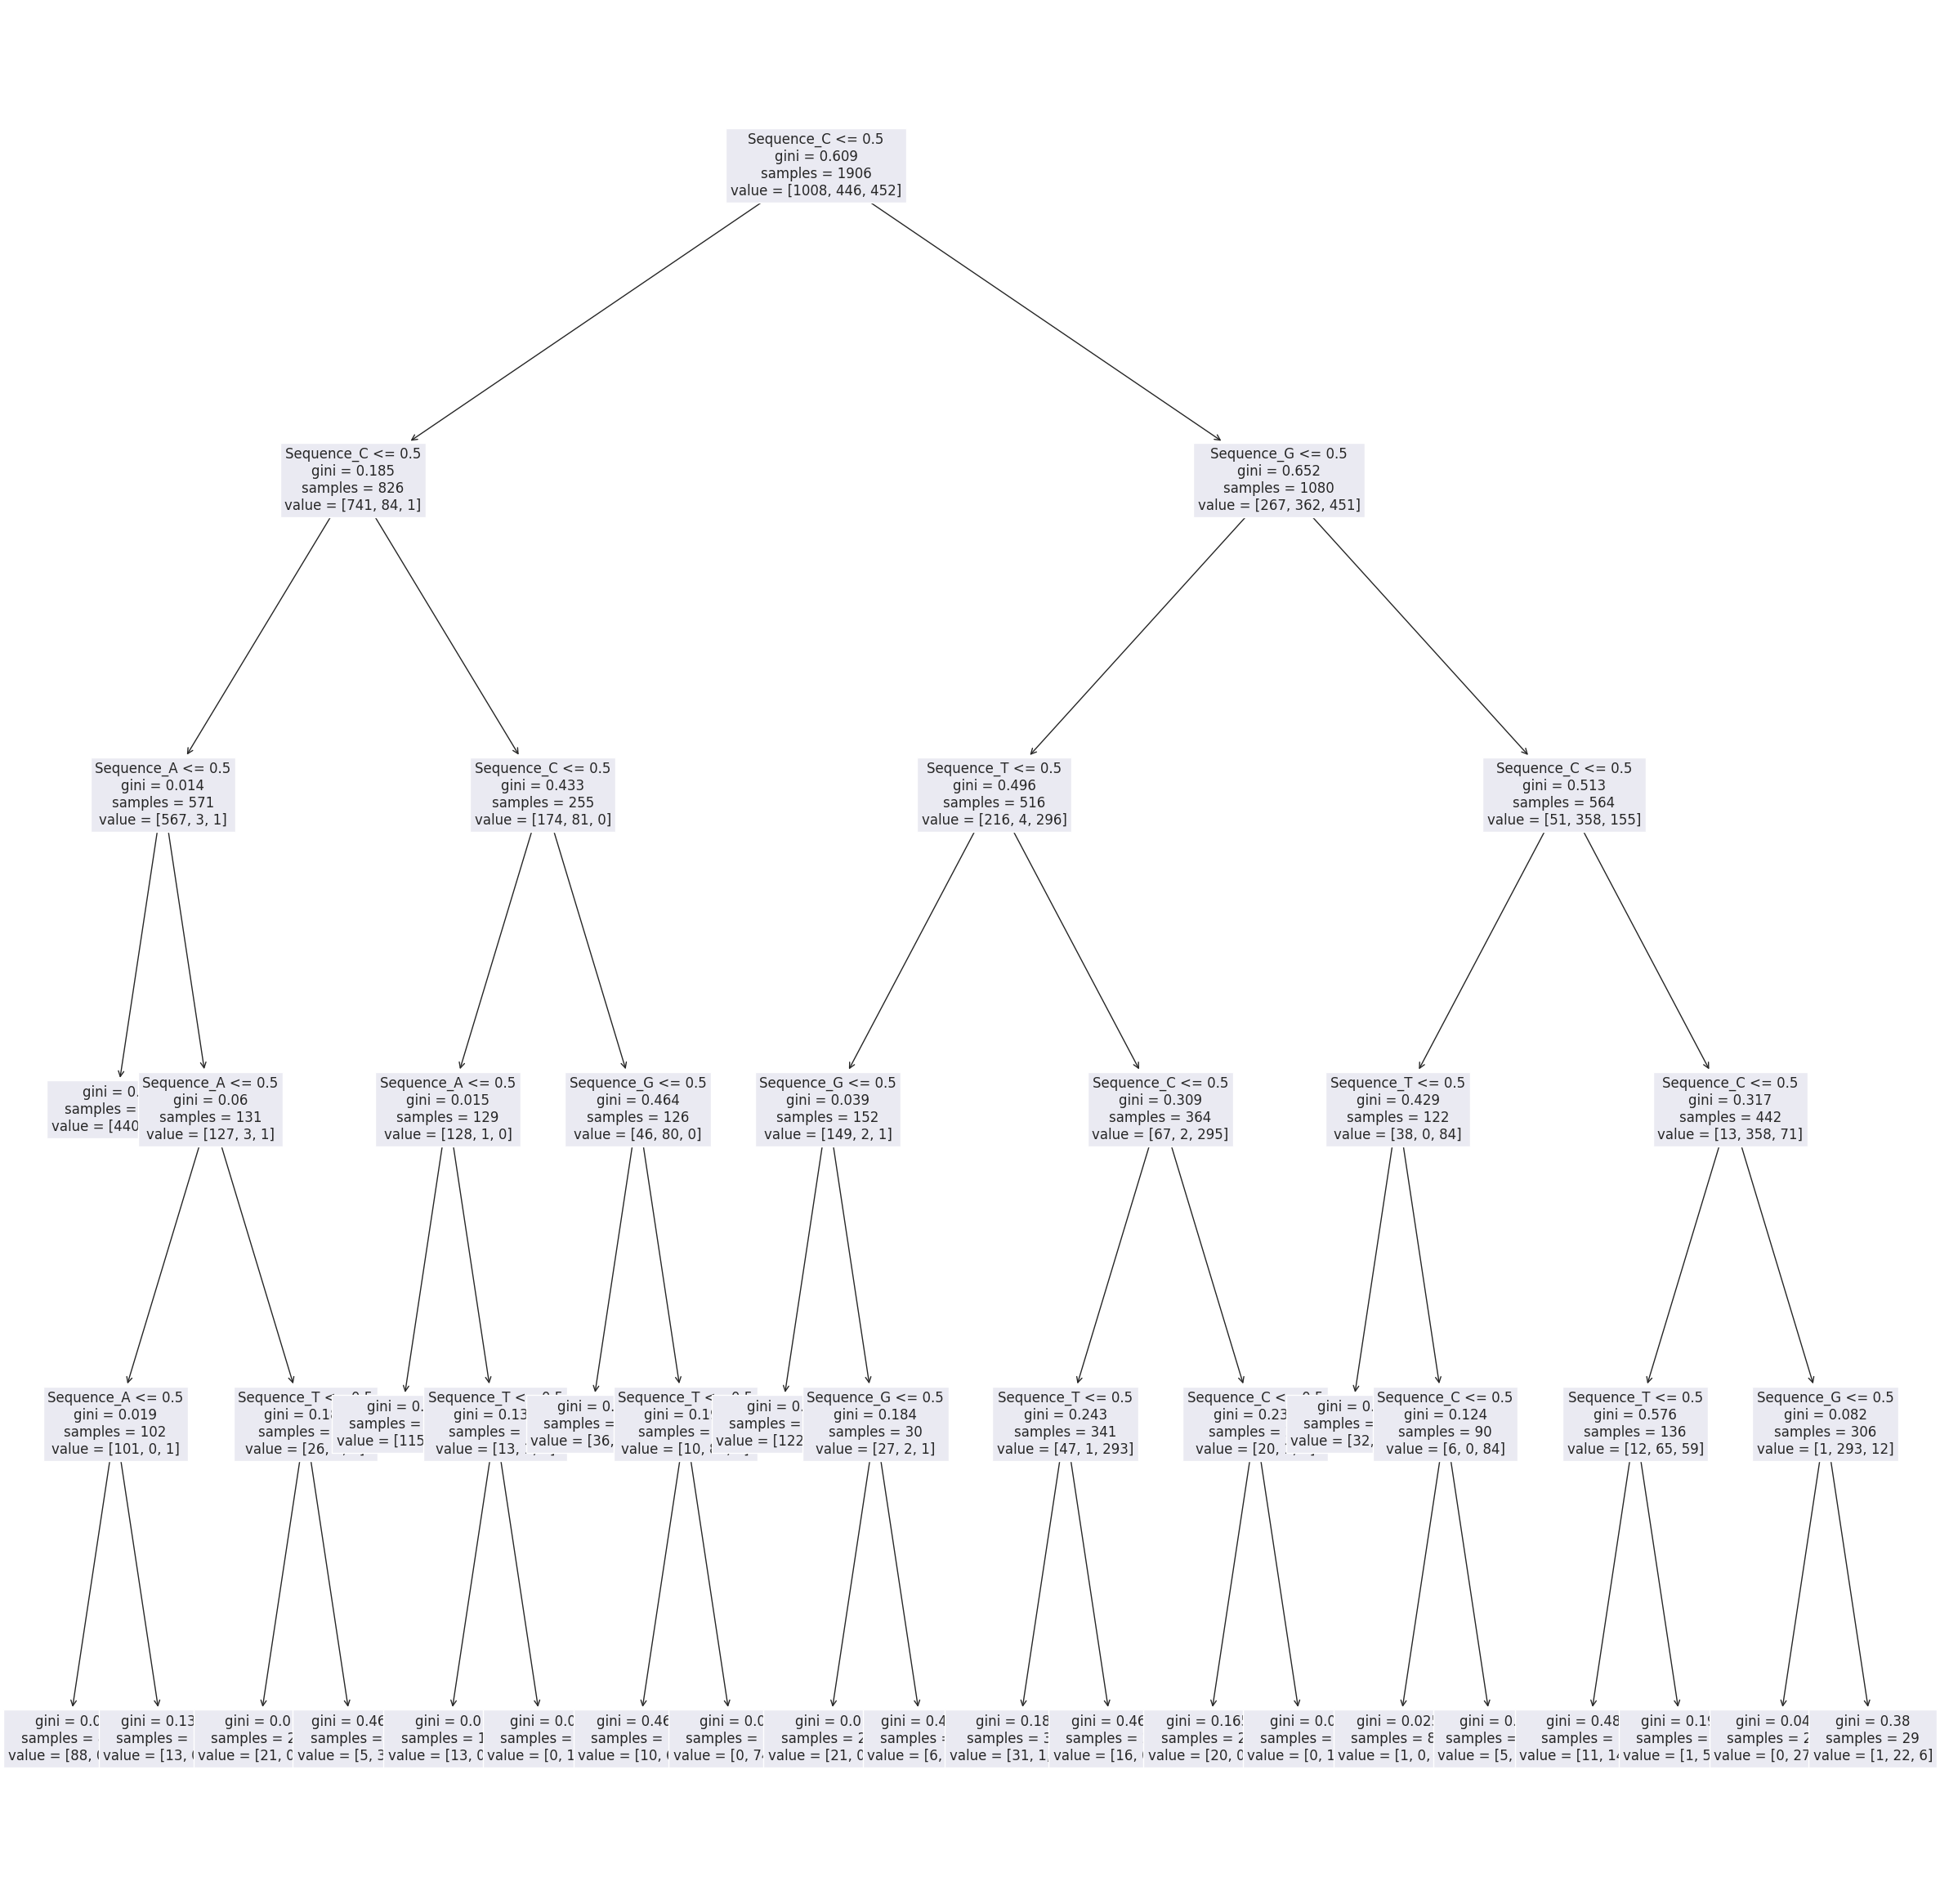

In [233]:
from sklearn import tree as tr
pyplot.figure(figsize=(30,30))
tr.plot_tree(tree,feature_names=data.columns[:-1], fontsize=12)
pyplot.show()

In [235]:
y_pred_dtc = tree.predict(X_test_s)
acc_dtc=accuracy_score(y_test, y_pred_dtc)
print("Accuracy for DTC:",acc_dtc)

Accuracy for DTC: 0.9386792452830188


Tuning model

In [236]:
from sklearn.model_selection import cross_val_score

# Assuming 'tree' is your decision tree model, and 'X_train', 'y_train' are your training data
scores = cross_val_score(tree, X_train_s, y_train, cv=5)  # 5-fold cross-validation
print(scores)

[0.93455497 0.92650919 0.91338583 0.9343832  0.93175853]


In [237]:
print("Avg Acc: " , scores.mean() , " std dev: ", scores.std(), " max: ", scores.max())

Avg Acc:  0.9281183438457627  std dev:  0.007919167357089453  max:  0.9345549738219895


In [238]:
param_grid = [
  {'min_samples_leaf': [1, 5, 10, 20,30,40],
   'max_depth': [3, 5, 9, 15,20,30,40,50],
   'criterion': ['gini', 'entropy']},
 ]

clf = GridSearchCV(tree, param_grid, cv=10)
#refit=true, default=True, refits the estimator using the best found parameters
#cv=None uses the default value which is 5

In [239]:
clf.fit(X_train_s, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(max_depth=5),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 5, 9, 15, 20, 30, 40, 50],
                          'min_samples_leaf': [1, 5, 10, 20, 30, 40]}])

In [240]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 10}

Multinomial NaiveBaiyes

In [241]:
mynb = MultinomialNB(alpha=0.1)   #alpha is Laplace smoothing parameter
mynb.fit(X_train_s, y_train)

MultinomialNB(alpha=0.1)

In [242]:
confusion_matrix(mynb.predict(X_test_s),y_test)

array([[634,  15,  15],
       [  9, 292,   7],
       [  4,   8, 288]])

In [243]:
from sklearn.metrics import classification_report, accuracy_score
print("Accuracy:", accuracy_score(mynb.predict(X_test_s),y_test))

Accuracy: 0.9544025157232704


Tuning hyperparameters

Part 2: Best alpha value = 0.1
Part 2: Best Test Accuracy = 0.9544025157232704


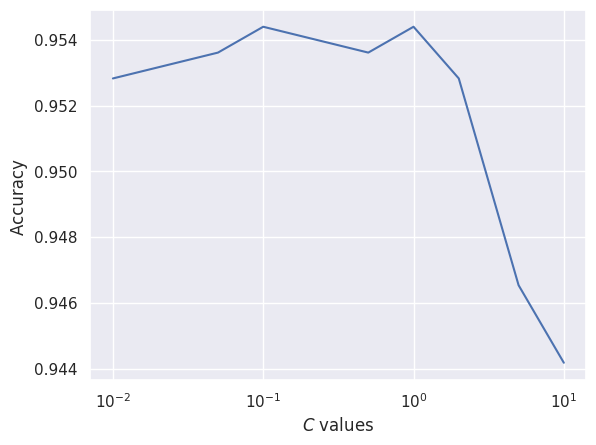

In [244]:
# Naive Baiyers
from matplotlib import pyplot
alpha_values = [0.01, 0.05, 0.1, 0.5, 1.0, 2, 5, 10] # We can adjust this range as needed

# Let best_accuracy is  obtained from above set of 'C' values and updated accordingly
best_accuracy = 0
best_alpha = 0
accuracy_results = np.zeros(8)
i=0

for alpha in alpha_values:
    model =  MultinomialNB(alpha=alpha)
    model.fit(X_train_s, y_train)
    test_accuracy = model.score(X_test_s, y_test)
    accuracy_results[i] = test_accuracy
    i=i+1


    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_alpha = alpha

print("Part 2: Best alpha value =", best_alpha)
print("Part 2: Best Test Accuracy =", best_accuracy)

#Plotting the results
x = np.array(range(0,10))
pyplot.plot( alpha_values, accuracy_results)
#help(pyplot.xscale)
pyplot.xscale('log')
pyplot.xlabel('$C$ values')
pyplot.ylabel('Accuracy ')
pyplot.show()


In [245]:
y_predicted_test = mynb.predict(X_test_s)
print("Classification report generated from the results of Naive Baiyes:")
print(classification_report(y_test, y_predicted_test))
sns.set(font_scale=1)

Classification report generated from the results of Naive Baiyes:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       647
           1       0.95      0.93      0.94       315
           2       0.96      0.93      0.94       310

    accuracy                           0.95      1272
   macro avg       0.95      0.95      0.95      1272
weighted avg       0.95      0.95      0.95      1272



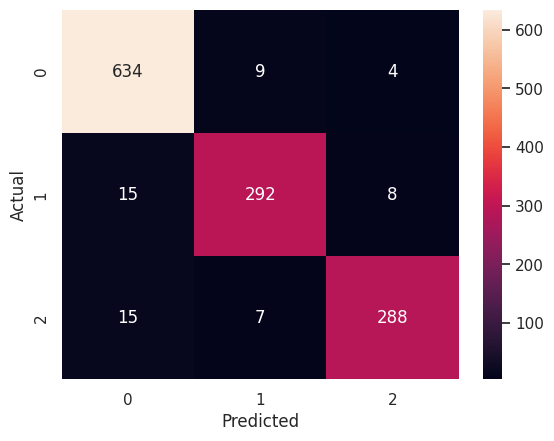

In [246]:
show_classification_matrix(y_test, y_predicted_test)

In [247]:
acc_nb = accuracy_score(mynb.predict(X_test_s),y_test)

Comparing results for all methods

In [248]:
data_scores = {
    'Classifier': ['Random Forest','Decision Tree','Naive Bayes','Logistic Rgression'],
    'accuracy_score': [acc_rfc, acc_dtc, acc_nb,acc_lr]
    }
df_accuracyscores = pd.DataFrame(data_scores)
df_accuracyscores

,Classifier,accuracy_score
0,Random Forest,0.968553
1,Decision Tree,0.938679
2,Naive Bayes,0.954403
3,Logistic Rgression,0.945755


In [249]:
print("\033[1mThe best model is RandomForest Classifier and the score is\033[1m", df_accuracyscores['accuracy_score'].max())

The best model is RandomForest Classifier and the score is 0.9685534591194969


**Visualizing the accuracy scores of the Classification Models**

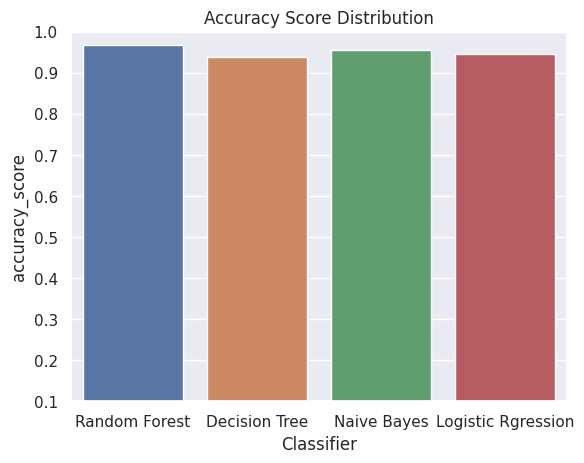

In [250]:
# Visualize the distribution of the target variable
sns.barplot(data=df_accuracyscores, x='Classifier', y='accuracy_score')
plt.gca().set_ylim(.1,1)
plt.title('Accuracy Score Distribution')
plt.show()

**Finding most important feature**

In [251]:
classifier_RFC = RandomForestClassifier(random_state=1)
classifier_RFC.fit(X_train_s, y_train)

feature_importances = pd.DataFrame(classifier_RFC.feature_importances_, index=data.columns[:-1], columns=['importance'])

# Print the feature importances
print("Feature Importances:", feature_importances)


Feature Importances:             importance
Class         0.001270
Sequence_A    0.001439
Sequence_C    0.001727
Sequence_G    0.001778
Sequence_T    0.001667
...                ...
Sequence_G    0.001508
Sequence_T    0.001937
Sequence_A    0.001725
Sequence_C    0.001872
Sequence_G    0.002082

[240 rows x 1 columns]


In [252]:
# Finding the most important feature
most_important_feature = feature_importances['importance'].idxmax()
most_important_feature_value = feature_importances['importance'].max()

print("\033[1mMost Important Feature is :\033[1m", most_important_feature, "\033[1mwith the importance value of \033[1m", most_important_feature_value)

Most Important Feature is : Sequence_T with the importance value of  0.08402610934896064
